In [ ]:
import os
import json
import wandb
import subprocess
import random
from tqdm import tqdm
from PIL import Image
import torch
import numpy as np
import io
from openai import OpenAI
import base64
from pydantic import BaseModel

# %%
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla

from sd_processor import JointAttnProcessor2_0
pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()

/home/wg25r/miniconda/envs/mochi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Using seed: 1748152867


100%|██████████| 16/16 [00:08<00:00,  1.80it/s]


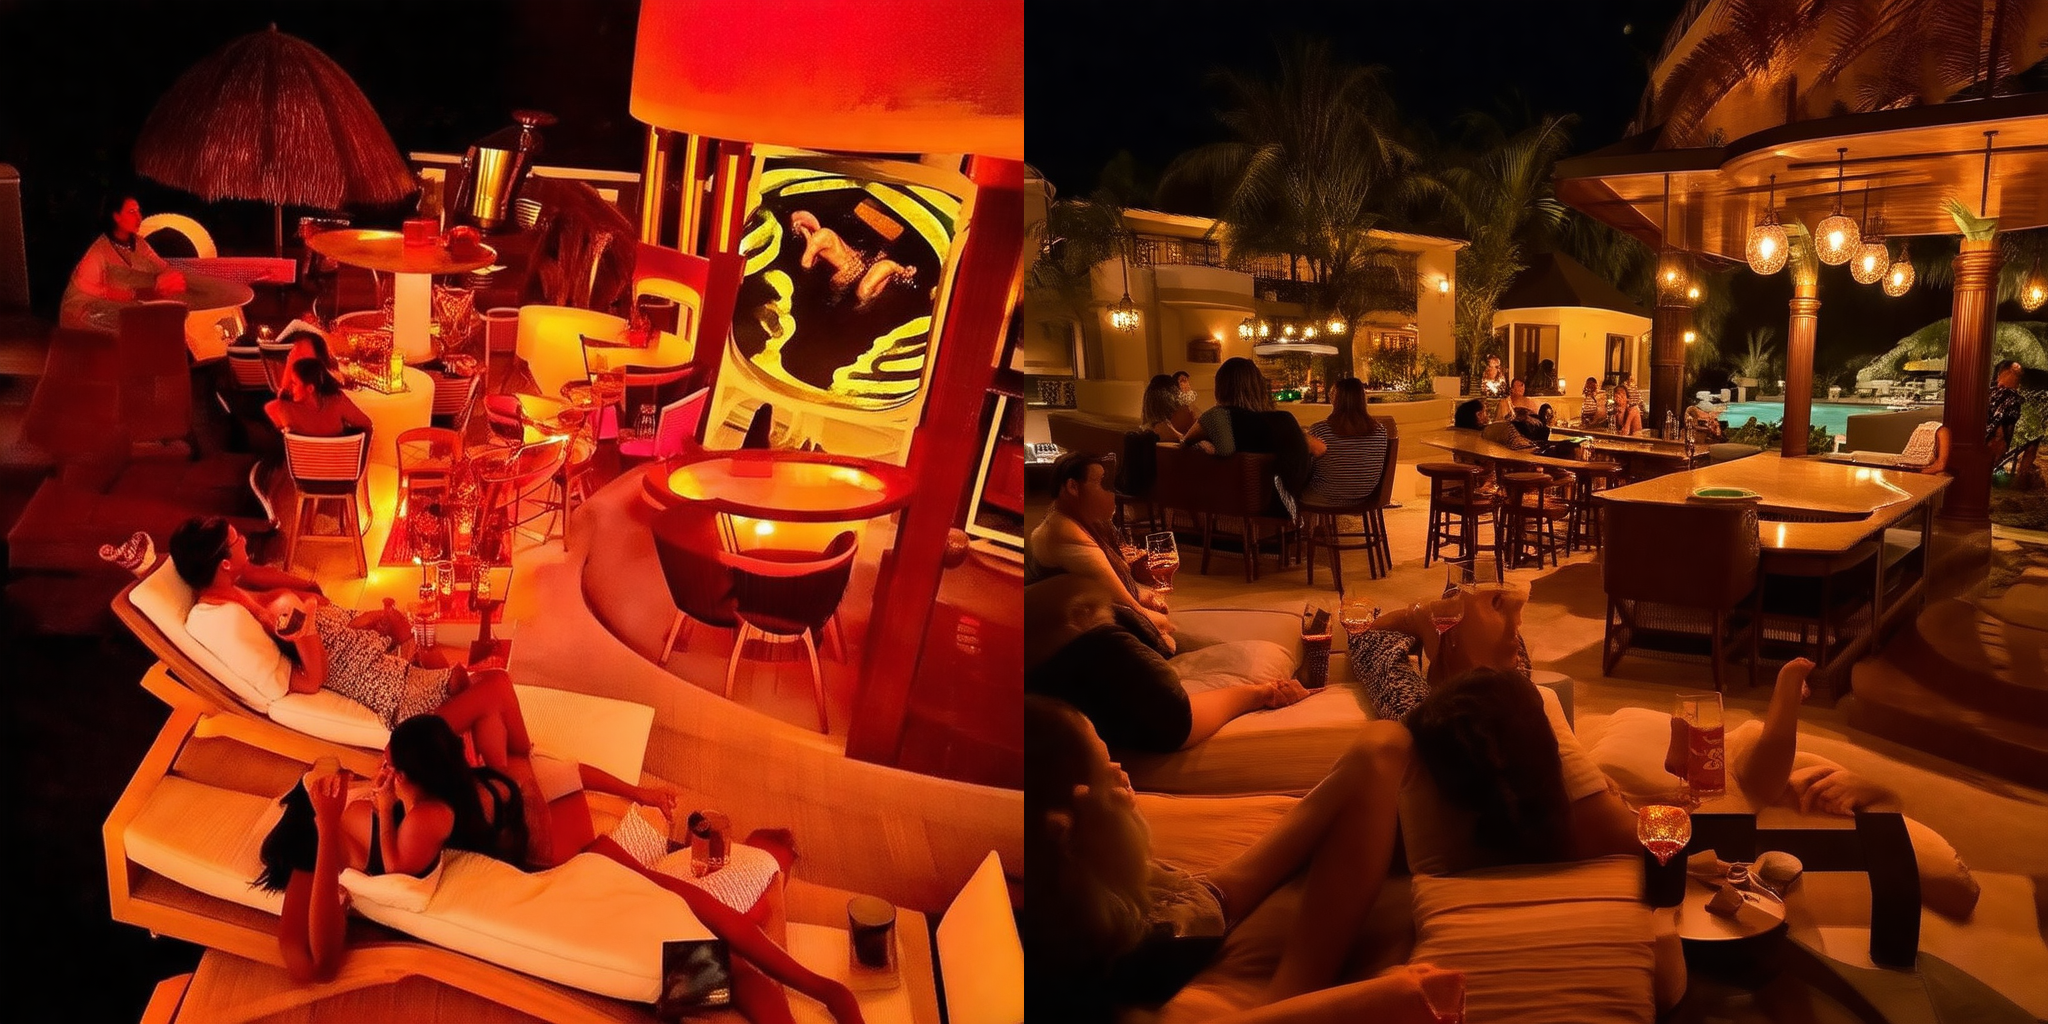

In [ ]:
positive_prompt = "A luxury resort's outdoor leisure area in the evening, with guests enjoying drinks at an outdoor bar, and others relaxing on sun loungers while some people swim in the open-air leisure space."
negative_prompt = "swimming pool"
import time
seed = int(time.time())
print(f"Using seed: {seed}")    

for block in pipe.transformer.transformer_blocks:
    block.attn.processor.neg_prompt_len=max([
        len(pipe.tokenizer.tokenize(negative_prompt)), 
        len(pipe.tokenizer_2.tokenize(negative_prompt)),
        len(pipe.tokenizer_3.tokenize(negative_prompt))
    ]) + 1 


image_ours = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=7,
    guidance_scale=7, 
    negative_offset=-6,
    clamp_value=15, 
    return_steps=1,
    generator=torch.manual_seed(seed),  
).images
negative_guidance_scales = pipe.negative_guidance_scales
weight_maps = pipe.weight_maps
image_vanilla = pipe(
    positive_prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    guidance_scale=7, 
    return_steps=1,
    vanilla=True,
    generator=torch.manual_seed(seed),
).images

Image.fromarray(
            np.concatenate(
                [np.array(image_ours[-1]), np.array(image_vanilla[-1])], axis=1
            ) 
 ) 

In [ ]:
import requests
from PIL import Image
import torch
from PIL import ImageDraw

from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-large-patch14-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-large-patch14-ensemble").to("cuda")

for image in [image_ours[-1], image_vanilla[-1]]:
  texts = [["swimming pool", "A luxury resort's outdoor leisure area in the evening."]]
  inputs = processor(text=texts, images=image, return_tensors="pt").to("cuda")

  with torch.no_grad():
    outputs = model(**inputs) 

  target_sizes = torch.Tensor([image.size[::-1]])
  results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
  i = 0
  text = texts[i]
  boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
  try:
    max_score_term0 = torch.max(scores[labels == 0])
  except RuntimeError:
    max_score_term0 = 0
    
  try:
    max_score_term1 = torch.max(scores[labels == 1])
  except RuntimeError:
    max_score_term1 = 0
  print(max_score_term0, max_score_term1, max_score_term1 - max_score_term0)

0 tensor(0.4334, device='cuda:0') tensor(0.4334, device='cuda:0')
tensor(0.2919, device='cuda:0') tensor(0.4922, device='cuda:0') tensor(0.2003, device='cuda:0')


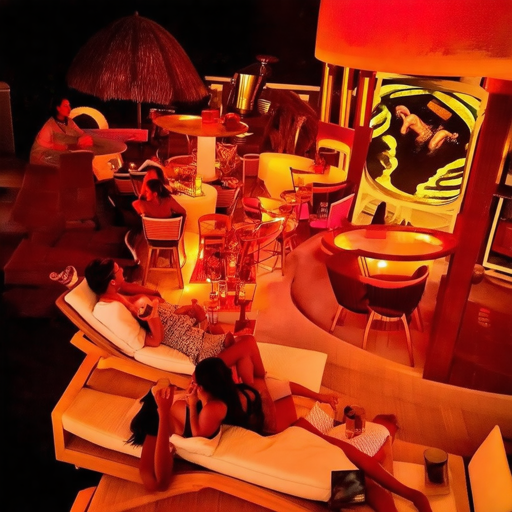

In [ ]:
texts = [["swimming pool", "A luxury resort's outdoor leisure area in the evening."]]
inputs = processor(text=texts, images=image_ours[-1], return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs) 

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# draw boxes with labels == 0
copy = image_ours[-1].copy()
draw = ImageDraw.Draw(copy)
for box, score, label in zip(boxes, scores, labels):
    if label == 0:
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{score.item():.2f}", fill="red")
copy.resize((512, 512))

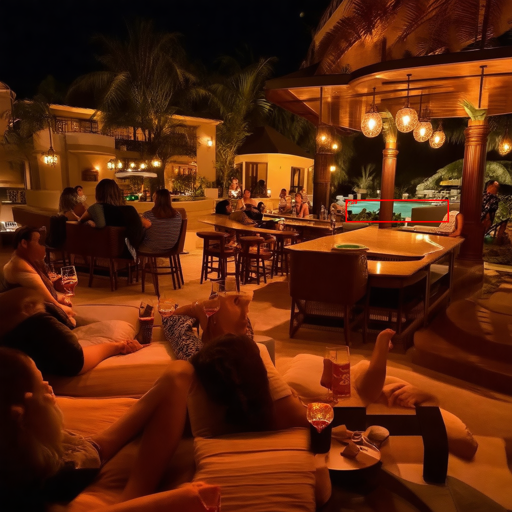

In [ ]:
texts = [["a normal swimming pool", "A luxury resort's outdoor leisure area in the evening."]]
inputs = processor(text=texts, images=image_vanilla[-1], return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs) 

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
max_score = torch.max(scores[labels == 0])
# draw boxes with labels == 0
copy = image_vanilla[-1].copy()
draw = ImageDraw.Draw(copy)
for box, score, label in zip(boxes, scores, labels):
    if label == 0 and score == max_score:
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{score.item():.2f}", fill="red")
copy.resize((512, 512))

In [ ]:

# frames = []
# for i in range(len(image_ours)):
#     frame = np.concatenate(
#         [np.array(image_ours[i]), np.array(image_vanilla[i])], axis=1
#     )
#     frames.append(Image.fromarray(frame))

# # save as a video
# import imageio
# imageio.mimwrite(
#     "sd3_ours_vs_vanilla.mp4",
#     frames,
#     fps=2,
# )


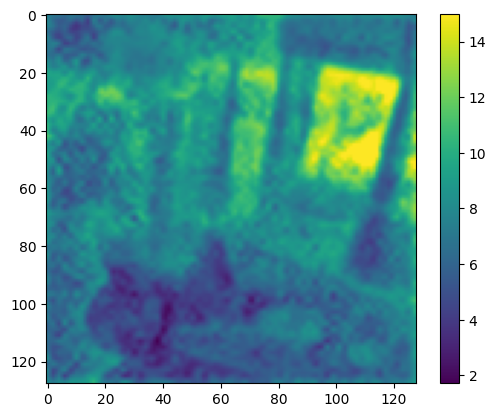

In [ ]:
import pylab
pylab.imshow(weight_maps[6].mean(0).mean(0).cpu().float().numpy())
pylab.colorbar()